# **😎 TensorFlow 年齡與性別估計（活頁簿 1：年齡估計）**

* 欲進行性別分類，請至 [活頁簿 2（性別分類）](https://colab.research.google.com/drive/1aOMbQYK2bvedNVXkZvHC_FsBsKrCx01P?usp=sharing)

在本筆記本中，我們將訓練一個 Keras 模型，根據 *已裁剪人臉* 圖片來估計一個人的年齡。我們使用著名的 [UTKFace 資料集](https://susanqq.github.io/UTKFace/)，該資料集包含 23,000 張影像，每張影像都標註了性別、年齡和族裔。

> **注意：請確認您已連接到 Google Colab 的 GPU 執行環境，否則訓練可能需要非常長的時間。請至「執行階段 > 變更執行類型 > 硬體加速器」中啟用 GPU。**



## 1) **下載 UTKFace 資料集** 💻



UTKFace 資料集可透過以下 Google 雲端硬碟資料夾取得。請下載並將其放入您的 Google 雲端硬碟中：[連結](https://drive.google.com/drive/folders/0BxYys69jI14kU0I1YUQyY1ZDRUE)。

完成後，請在本筆記本中掛載您的 Google 雲端硬碟。


In [ ]:

from google.colab import drive

drive.mount('/content/drive')


將 `utkface_23k.zip` 檔案解壓縮到本地目錄。這樣可以大幅加快圖片解析的速度。詳情請參考 StackOverflow 的 [這篇回答](https://stackoverflow.com/a/60802388/10878733)。


In [ ]:

# Replace with your path!
!unzip -q /content/drive/MyDrive/Datasets/utkface_23k.zip -d data


'unzip' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC


將目錄名稱從 `utkace_23k` 更改為 `utkface23k`，以移除底線，否則在拆分檔名取得年齡時可能會導致錯誤。


In [ ]:

!mv data/utkface_23k data/utkface23k


In [25]:

# # To download checkpoints, Keras models, TFLite models
# from google.colab import files

# Life is incomplete without this statement!
import tensorflow as tf

# And this as well!
import numpy as np

# To visualize results
import matplotlib.pyplot as plt

import os
import datetime

from pathlib import Path


## 2) **資料處理** 🦾

下載資料集後，我們需要對其執行下列操作，以便後續用於模型訓練：

* 👉🏻 將影像檔讀取為 3 維 NumPy 陣列。注意，我們將使用三通道 RGB 影像作為模型輸入，因此每個陣列的形狀為 `[影像寬度, 影像高度, 3]`。

* 👉🏻 拆分檔名以解析影像中人物的年齡。我們使用 `tf.strings.split()` 方法來完成此任務。

* 👉🏻 目標變數的最大值為 116 歲，用於將 `age` 欄位正規化。

完成上述操作後，我們會得到 N 個樣本，每個樣本包含影像陣列（形狀 `[200, 200, 3]`）及其對應標籤――該人物的年齡（形狀 `[1]`）。

我們將使用 `tf.data.Dataset` 來提升資料處理速度，並利用平行運算優化效能。上述兩個操作將透過 `tf.data.Dataset.map` 方法，映射到每個檔名上進行處理。  


In [26]:
# ----------------------------------------
# 參數設定
# ----------------------------------------
MODEL_INPUT_IMAGE_SIZE = [200, 200]   # 模型輸入影像大小
TRAIN_TEST_SPLIT        = 0.3         # 測試集比例（留作後續用）
N                       = 20000       # 取樣筆數

# ----------------------------------------
# 建立資料夾路徑
# ----------------------------------------
# 如果 __file__ 存在，就以此檔案所在資料夾為基準；否則用目前工作目錄
try:
    BASE_DIR = Path(__file__).resolve().parent
except NameError:
    BASE_DIR = Path.cwd()

# 因為你的 dataset 資料夾在 RefProgram 的上層，所以往上跳一層
PROJECT_ROOT = BASE_DIR.parent  
UTKFACE_DIR  = PROJECT_ROOT / "dataset" / "archive" / "UTKFace"

if not UTKFACE_DIR.exists():
    raise FileNotFoundError(f"找不到資料夾：{UTKFACE_DIR}")

# ----------------------------------------
# 影像與標籤解析函式
# ----------------------------------------
def parse_image(filename):
    image_raw = tf.io.read_file(filename)
    image      = tf.image.decode_jpeg(image_raw, channels=3)
    image      = tf.image.resize(image, MODEL_INPUT_IMAGE_SIZE) / 255.0

    # 取出純檔名
    fname = tf.strings.split(filename, os.sep)[-1]
    parts = tf.strings.split(fname, "_")
    age   = tf.strings.to_number(parts[0], out_type=tf.float32) / 116.0

    return image, age

# ----------------------------------------
# 建立 TensorFlow Dataset
# ----------------------------------------
pattern = str(UTKFACE_DIR / "*.chip.jpg")
list_ds = tf.data.Dataset.list_files(pattern, shuffle=True)

dataset = (
    list_ds
    .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    .take(N)
)

# ----------------------------------------
# 範例：列印前 5 筆結果
# ----------------------------------------
for idx, (img, lbl) in enumerate(dataset.take(5)):
    print(f"[{idx:02d}] image.shape = {img.shape}, age = {lbl.numpy():.4f}")

[00] image.shape = (200, 200, 3), age = 0.3103
[01] image.shape = (200, 200, 3), age = 0.5172
[02] image.shape = (200, 200, 3), age = 0.2414
[03] image.shape = (200, 200, 3), age = 0.0603
[04] image.shape = (200, 200, 3), age = 0.2500


我們從資料集中建立兩個子集，一個用於訓練模型，另一個用於測試模型。用於測試模型的資料比例由 `TRAIN_TEST_SPLIT` 參數決定。


In [27]:

# Create train and test splits of the dataset.
num_examples_in_test_ds = int( dataset.cardinality().numpy() * TRAIN_TEST_SPLIT )

test_ds = dataset.take( num_examples_in_test_ds )
train_ds = dataset.skip( num_examples_in_test_ds )

print( 'Num examples in train ds {}'.format( train_ds.cardinality() ) )
print( 'Num examples in test ds {}'.format( test_ds.cardinality() ) )


Num examples in train ds 14000
Num examples in test ds 6000



## 3) **CNN 模型** 👨‍🎓

在我們的方法中，將年齡估計視為迴歸問題。我們的目標是設計一個參數更少（意味著推論時間與模型大小更小），卻仍具有強大表現力以提高泛化能力的模型。

* 👉🏻 模型接受形狀為 `[None, 200, 200, 3]` 的輸入批次，並依據 `num_blocks` 參數執行多層捲積運算。  
* 👉🏻 每個 Block 包含以下層序列：`Conv2D → BatchNorm → LeakyReLU`


```
# Define the conv block.
if lite_model:
        x = tf.keras.layers.SeparableConv2D( num_filters ,
                                            kernel_size=kernel_size ,
                                            strides=strides
                                            , use_bias=False ,
                                            kernel_initializer=tf.keras.initializers.HeNormal() ,
                                            kernel_regularizer=tf.keras.regularizers.L2( 1e-5 )
                                             )( x )
    else:
        x = tf.keras.layers.Conv2D( num_filters ,
                                   kernel_size=kernel_size ,
                                   strides=strides ,
                                   use_bias=False ,
                                   kernel_initializer=tf.keras.initializers.HeNormal() ,
                                   kernel_regularizer=tf.keras.regularizers.L2( 1e-5 )
                                    )( x )

    x = tf.keras.layers.BatchNormalization()( x )
    x = tf.keras.layers.LeakyReLU( leaky_relu_alpha )( x )
```

* 若將 `lite_model` 設為 `True`，則使用[可分離捲積（Separable Convolutions）](https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728)，可減少參數量，換取更快速的推論速度，但可能略微犧牲效能。

* 👉🏻 我們依序堆疊 `num_blocks` 個此類 Block，每層的過濾器數量由 `num_filters` 決定。

* 👉🏻 接著加入多層 `Dense` 全連接層，以學習由捲積層所提取的特徵；同時插入 `Dropout` 層以減少過擬合。每層 `Dropout` 的 `rate` 會逐層遞減，確保單位數較少的全連接層仍具備良好可學習性。


```
def dense( x , filters , dropout_rate ):
    x = tf.keras.layers.Dense( filters , kernel_regularizer=tf.keras.regularizers.L2( 0.1 ) , bias_regularizer=tf.keras.regularizers.L2( 0.1 ) )( x )
    x = tf.keras.layers.LeakyReLU( alpha=leaky_relu_alpha )( x )
    x = tf.keras.layers.Dropout( dropout_rate )( x )
    return x
```

> 如需選擇上述兩個區塊中所使用的權重衰減值，請參考 [這篇部落格](https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/)。

* 👉🏻 模型的輸出是一個形狀為 `[None, 1]` 的張量。



In [28]:

# Negative slope coefficient for LeakyReLU.
leaky_relu_alpha = 0.2

lite_model = False

# Define the conv block.
def conv( x , num_filters , kernel_size=( 3 , 3 ) , strides=1 ):
    if lite_model:
        x = tf.keras.layers.SeparableConv2D( num_filters ,
                                            kernel_size=kernel_size ,
                                            strides=strides,
                                            use_bias=False ,
                                            kernel_initializer=tf.keras.initializers.HeNormal() ,
                                            kernel_regularizer=tf.keras.regularizers.L2( 1e-5 )
                                             )( x )
    else:
        x = tf.keras.layers.Conv2D( num_filters ,
                                   kernel_size=kernel_size ,
                                   strides=strides ,
                                   use_bias=False ,
                                   kernel_initializer=tf.keras.initializers.HeNormal() ,
                                   kernel_regularizer=tf.keras.regularizers.L2( 1e-5 )
                                    )( x )

    x = tf.keras.layers.BatchNormalization()( x )
    x = tf.keras.layers.LeakyReLU( leaky_relu_alpha )( x )
    return x

def dense( x , filters , dropout_rate ):
    x = tf.keras.layers.Dense( filters , kernel_regularizer=tf.keras.regularizers.L2( 0.1 ) , bias_regularizer=tf.keras.regularizers.L2( 0.1 ) )( x )
    x = tf.keras.layers.LeakyReLU( alpha=leaky_relu_alpha )( x )
    x = tf.keras.layers.Dropout( dropout_rate )( x )
    return x


# No. of convolution layers to be added.
num_blocks = 6
# Num filters for each conv layer.
num_filters = [ 16 , 32 , 64 , 128 , 256 , 256 ]
# Kernel sizes for each conv layer.
kernel_sizes = [ 3 , 3 , 3 , 3 , 3 , 3 ]

# Init a Input Layer.
inputs = tf.keras.layers.Input( shape=MODEL_INPUT_IMAGE_SIZE + [ 3 ] )

# Add conv blocks sequentially
x = inputs
for i in range( num_blocks ):
    x = conv( x , num_filters=num_filters[ i ] , kernel_size=kernel_sizes[ i ] )
    x = tf.keras.layers.MaxPooling2D()( x )

# Flatten the output of the last Conv layer.
x = tf.keras.layers.Flatten()( x )
conv_output = x

# Add Dense layers ( Dense -> LeakyReLU -> Dropout )
x = dense( conv_output , 256 , 0.6 )
x = dense( x , 64 , 0.4 )
x = dense( x , 32 , 0.2 )
outputs = tf.keras.layers.Dense( 1 , activation='relu' )( x )

# Build the Model
model = tf.keras.models.Model( inputs , outputs )

# Uncomment the below to view the summary of the model.
model.summary()
# tf.keras.utils.plot_model( model , to_file='architecture.png' )


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 198, 198, 16)      432       
_________________________________________________________________
batch_normalization_12 (Batc (None, 198, 198, 16)      64        
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 198, 198, 16)      0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 97, 97, 32)        4608      
_________________________________________________________________
batch_normalization_13 (Batc (None, 97, 97, 32)        128 

## 4) **編譯模型（及其他 Callback）** 🧱

定義完模型架構後，我們將編譯 Keras 模型並初始化一些有用的 Callback。

* 👉🏻 由於我們進行的是迴歸任務，因此使用平均絕對誤差（Mean Absolute Error, MAE）作為損失函數。詳情請參考 [`tf.keras.losses.mean_absolute_error`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MAE)。

* 👉🏻 使用 Adam 優化器來訓練模型。詳情請參考 [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)。

* 👉🏻 為了評估模型效能，我們也將 MAE 作為評估指標。詳情請參考 [`tf.keras.metrics.MeanAbsoluteError`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanAbsoluteError)。

#### Callback：

* 👉🏻 [`tf.keras.callbacks.ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)：在每個 epoch 結束後，將模型儲存為 H5 檔案。

* 👉🏻 [`tf.keras.callbacks.TensorBoard`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard)：使用 TensorBoard 可視化訓練過程。

* 👉🏻 [`tf.keras.callbacks.LearningRateScheduler`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler)：根據指定的 epoch 數量動態降低學習率，以便在優化器接近損失函數極小值時採取更小的步伐。

```
def scheduler( epochs , learning_rate ):
    if epochs < num_epochs * 0.25:
        return learning_rate
    elif epochs < num_epochs * 0.5:
        return 0.0005
    elif epochs < num_epochs * 0.75:
        return 0.0001
    else:
        return 0.000095
```

* 👉🏻 [`tf.keras.callbacks.EarlyStopping`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)：當測試資料集上的評估指標（即 MAE）不再改善時，停止訓練。







In [29]:

# Initial learning rate
learning_rate = 0.001

num_epochs = 50 #@param {type: "number"}
batch_size = 128 #@param {type: "number"}

# Batch and repeat `train_ds` and `test_ds`.
train_ds = train_ds.batch( batch_size )
test_ds = test_ds.batch( batch_size )

# Init ModelCheckpoint callback
save_dir_ = 'model_1'  #@param {type: "string"}
save_dir = save_dir_ + '/{epoch:02d}-{val_mae:.2f}.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    save_dir ,
    save_best_only=True ,
    monitor='val_mae' ,
    mode='min' ,
)

tb_log_name = 'model_1'  #@param {type: "string"}
# Init TensorBoard Callback
logdir = os.path.join( "tb_logs" , tb_log_name )
tensorboard_callback = tf.keras.callbacks.TensorBoard( logdir )

# Init LR Scheduler
def scheduler( epochs , learning_rate ):
    if epochs < num_epochs * 0.25:
        return learning_rate
    elif epochs < num_epochs * 0.5:
        return 0.0005
    elif epochs < num_epochs * 0.75:
        return 0.0001
    else:
        return 0.000095

lr_schedule_callback = tf.keras.callbacks.LearningRateScheduler( scheduler )

# Init Early Stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping( monitor='val_mae' , patience=10 )

# Compile the model
model.compile(
    loss=tf.keras.losses.mean_absolute_error ,
    optimizer = tf.keras.optimizers.Adam( learning_rate ) ,
    metrics=[ 'mae' ]
)


執行此程式區塊，以在本筆記本中直接使用 TensorBoard 可視化模型訓練過程。



In [30]:

%load_ext tensorboard
%tensorboard --logdir tb_logs/


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 34752), started 0:08:28 ago. (Use '!kill 34752' to kill it.)

## 5) **訓練與評估模型** 🏋🏻‍♂️

將所有 Callback 一次打包後，開始執行訓練迴圈。


In [31]:

model.fit(
    train_ds,
    epochs=num_epochs,
    validation_data=test_ds,
    callbacks=[ checkpoint_callback , tensorboard_callback , lr_schedule_callback , early_stopping_callback ]
)


Epoch 1/50
110/110 [==============================] - 56s 474ms/step - loss: 14.2447 - mae: 0.2094 - val_loss: 2.4582 - val_mae: 0.1416
Epoch 2/50
110/110 [==============================] - 50s 439ms/step - loss: 0.9953 - mae: 0.1039 - val_loss: 0.3948 - val_mae: 0.1214
Epoch 3/50
110/110 [==============================] - 49s 431ms/step - loss: 0.2359 - mae: 0.0921 - val_loss: 0.1827 - val_mae: 0.1120
Epoch 4/50
110/110 [==============================] - 50s 441ms/step - loss: 0.1389 - mae: 0.0864 - val_loss: 0.1333 - val_mae: 0.0900
Epoch 5/50
110/110 [==============================] - 51s 447ms/step - loss: 0.1187 - mae: 0.0792 - val_loss: 0.1180 - val_mae: 0.0796
Epoch 6/50
110/110 [==============================] - 52s 457ms/step - loss: 0.1114 - mae: 0.0739 - val_loss: 0.1119 - val_mae: 0.0745
Epoch 7/50
110/110 [==============================] - 54s 470ms/step - loss: 0.1078 - mae: 0.0720 - val_loss: 0.1103 - val_mae: 0.0737
Epoch 8/50
110/110 [==============================] - 

評估模型。


In [32]:

p = model.evaluate( test_ds )
print( p )


47/47 [==============================] - 5s 109ms/step - loss: 0.0483 - mae: 0.0242
[0.04827411472797394, 0.0241685938090086]


（選用）載入 `.h5` 檔案進行評估。注意：請先執行建立 `train_ds` 和 `test_ds` 的程式區塊。

In [ ]:

batch_size = 128

model = tf.keras.models.load_model( 'model_lite_age.h5' )
p = model.evaluate( test_ds.batch( batch_size ) )
print( p )




將 Keras 模型儲存到本機磁碟，以便日後需要時能夠繼續訓練。


In [39]:

model_name = 'model_age' #@param {type: "string"}
model_name_ = model_name + '.h5'

model.save( model_name_ )
# files.download( model_name_ )


## 6) **可視化結果**

我們將從 `test_ds` 中取出一些影像進行年齡預測，並使用 `matplotlib` 繪製結果。


C:\Users\chenk\AppData\Local\Temp\ipykernel_14460\1430501560.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_ = int( model.predict( np.expand_dims( image , 0 ) ) * 116 )


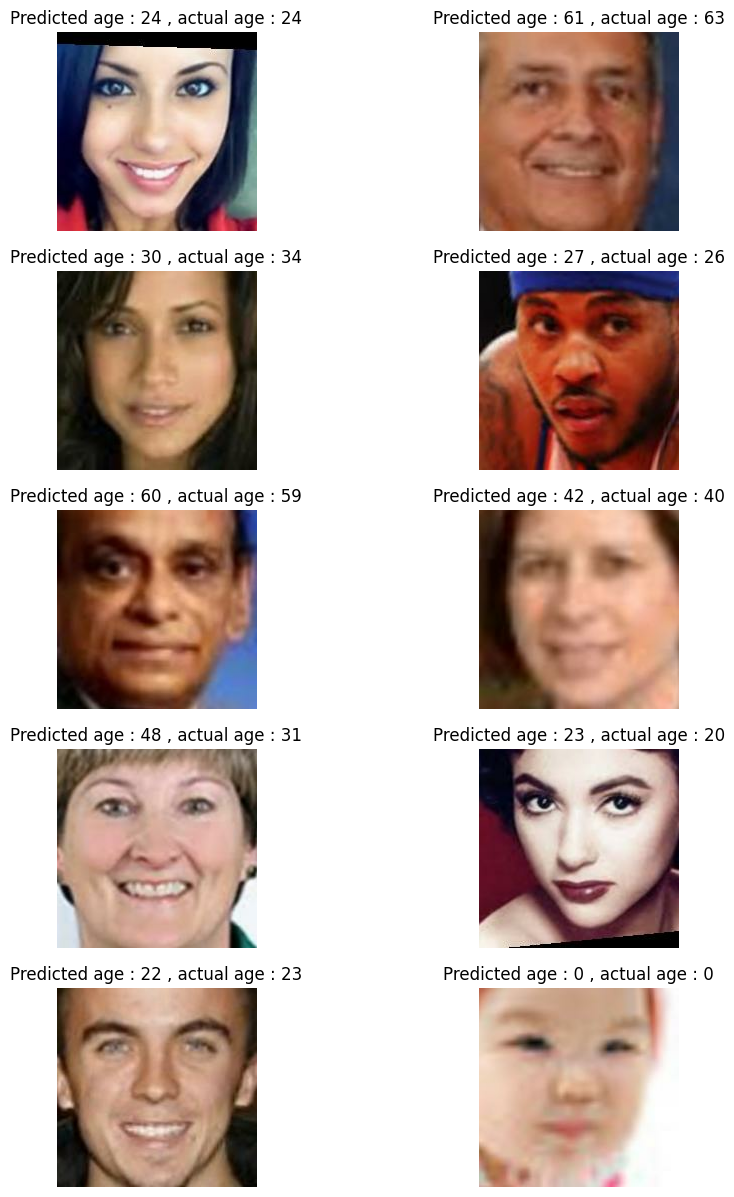

In [35]:

fig = plt.figure( figsize=( 10 , 15 ) )
rows = 5
columns = 2

i = 1
for image , label in test_ds.unbatch().take( 10 ):
    image = image.numpy()
    fig.add_subplot( rows , columns , i )
    plt.imshow( image )
    label_ = int( model.predict( np.expand_dims( image , 0 ) ) * 116 )
    plt.axis( 'off' )
    plt.title( 'Predicted age : {} , actual age : {}'.format( label_ , int( label.numpy() * 116 ) ) )
    i += 1


## 7) **轉換為 TensorFlow Lite 格式** 📡

我們的模型將部署在 Android 應用程式中，會使用 [TF Lite Android](https://bintray.com/google/tensorflow/tensorflow-lite) 套件來載入模型並進行推論。

我們使用 `TFLiteConverter` API 將 Keras 模型（`.h5`）轉換為 TF Lite 格式（`.tflite`）。詳情請參考官方文件：[TFLiteConverter](https://www.tensorflow.org/api_docs/python/tf/lite/TFLiteConverter)。  
最終會產出兩個 TF Lite 檔案：  
1. 使用 float16 量化的版本  
2. 未量化的版本  


In [40]:

converter = tf.lite.TFLiteConverter.from_keras_model( model )
converter.optimizations = [ tf.lite.Optimize.DEFAULT ]
converter.target_spec.supported_types = [ tf.float16 ]
buffer = converter.convert()

open( '{}_q.tflite'.format( model_name ) , 'wb' ).write( buffer )
# files.download( '{}_q.tflite'.format( model_name ) )


INFO:tensorflow:Assets written to: C:\Users\chenk\AppData\Local\Temp\tmpjyn3ozmw\assets


INFO:tensorflow:Assets written to: C:\Users\chenk\AppData\Local\Temp\tmpjyn3ozmw\assets


2144848


將模型轉換為未量化的 TF Lite 緩衝區。


In [42]:

converter = tf.lite.TFLiteConverter.from_keras_model( model )
buffer = converter.convert()

open( '{}_nonq.tflite'.format( model_name ) , 'wb' ).write( buffer )
# files.download( '{}_nonq.tflite'.format( model_name ) )


INFO:tensorflow:Assets written to: C:\Users\chenk\AppData\Local\Temp\tmpdjx_33et\assets


INFO:tensorflow:Assets written to: C:\Users\chenk\AppData\Local\Temp\tmpdjx_33et\assets


4275744

## 輔助方法

使用這些方法來自動化部分任務。

In [ ]:

#@title Utility to zip and download a directory
#@markdown Use this method to zip and download a directory. For ex. a TB logs
#@markdown directory or a checkpoint(s) directory.

dir_to_zip = 'tb_logs' #@param {type: "string"}
output_filename = 'logs.zip' #@param {type: "string"}
delete_dir_after_download = "No"  #@param ['Yes', 'No']

os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

if delete_dir_after_download == "Yes":
    os.system( "rm -r {}".format( dir_to_zip ) )

files.download( output_filename )


In [ ]:

#@title Utility to delete a directory
#@markdown Use this method to delete a directory.

dir_path = ''  #@param {type: "string"}
os.system( f'rm -r {dir_path}')



# LICENSE

```
  
MIT License

Copyright (c) 2021 Shubham Panchal

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```
